In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib
import pandas as pd
matplotlib.use('agg')
import matplotlib.pyplot as plt
import random
import re

from sklearn import model_selection

/home/asr/tensorflow-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/asr/tensorflow-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from stop_words import get_stop_words

In [4]:
ROOT_PATH='/home/asr/prj_SlotTagger/dnn_train'

## E/è Ambiguity Problem: VERB or CONJ?

In [5]:
%%time

num_lines_num  = sum(1 for line in open(ROOT_PATH + '/amb_raw/è_e_600k/cong/e_cong_max10_v1'))
num_lines_ver  = sum(1 for line in open(ROOT_PATH + '/amb_raw/è_e_600k/ver/è_verb_max10_v3'))

ratio = num_lines_ver  / float(num_lines_num) 
print('Corpus_six_num: %d, Corpus_six_ver: %d, Ratio: %0.3f' %(num_lines_num, num_lines_ver, ratio)) 

Corpus_six_num: 599901, Corpus_six_ver: 599997, Ratio: 1.000
CPU times: user 276 ms, sys: 18 ms, total: 294 ms
Wall time: 451 ms


In [138]:
! wc -l /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/cong/*

  599901 /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/cong/e_cong_max10_v1
    5000 /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/cong/e_nepero5k
     349 /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/cong/trenup_uniform_v1_e
  605250 total


In [139]:
! wc -l /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/ver/*

       5 /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/ver/additinal_è
   25000 /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/ver/c_è_without_e_è_25k
   25000 /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/ver/comeè_without_e_è_25k
   25000 /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/ver/doveè_without_e_è_25k
    4578 /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/ver/quantoè_without_e_è
    1000 /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/ver/trenup_uniform_v1_è
  599997 /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e_600k/ver/è_verb_max10_v3
  680580 total


## Building the Data-Frame (Balanced)

In [19]:
# Ad hoc sentences

months = ['gennaio', 'febbraio', 'marzo', 'aprile', 'maggio', 'giugno', 'luglio', 'agosto','settembre', 
          'ottobre','novembre','dicembre']
mdays = ['il primo', 'il due', 'il tre', 'il quarto', 'il cinque',
        'il sei', 'il sette', 'l otto', 'il nove', 'il dieci', 'l undici', 'il dodoci',
        'il tredici', 'il quattordici', 'il quindici', 'il sedici', 'il diciasette', 'il diciotto',
        'il diciannove', 'il venti', 'il ventuno', 'il ventun', 'il ventidue', 'il ventitre', 'il ventiquattro',
        'il venticinque', 'il ventisei', 'il ventisette', 'il ventotto', 'il ventinove', 
         'il trenta', 'il trentuno', 'il trentun']

è_verb_adhoc = []

alphabet = 'qwertyuiopasdfghjklzxcvbnmèòà'
alphabet = [x for x in alphabet]
ww = lambda x: ''.join([random.choice(alphabet) for i in range(x)])

for i in range(300):
    length = [3,4,5,6,7,8,9]
    length = random.choice(length)
    period = ['', '', '', '', '', '', '', 'bixby', 'ehi bixby', 'ciao bixby']
    dimmi = ['sai', 'dimmi', 'conosci', '', '', '', '', '', '', '', '']
    s1 = '%s %s che differenza c è tra %s' %(random.choice(period), random.choice(dimmi),  ww(length))
    #print(s1)
    è_verb_adhoc.append(s1)


for i in range(1000):
    bixby = ['', '', '', '', '', '', '', 'bixby', 'ehi bixby', 'ciao bixby']
    period = ['', '', '', '', '','del mese', 'dell anno', 'della settimana']
    s1 = '%s che giorno %s è %s %s' %(random.choice(bixby), random.choice(period), 
                                         random.choice(mdays), random.choice(months))
    è_verb_adhoc.append(s1)
  
santi = open("./amb_raw/name_entities/santi.txt", "r")
santi = [ line.rstrip().lower() for line in santi ]

for i in range(100):
    bixby = ['', '', '', '', '', '', '', 'bixby', 'ehi bixby', 'ciao bixby']
    period = ['', '', '', '', '','del mese', 'dell anno', 'della settimana']
    rnd = np.random.uniform()
    if rnd < .9:
        s1 = '%s che giorno %s è sant %s' %(random.choice(bixby), random.choice(period), 
                                         random.choice(santi))
    else:
        s1 = '%s in che giorno %s è sant %s' %(random.choice(bixby), random.choice(period), 
                                         random.choice(santi))
    #print(s1)
    è_verb_adhoc.append(s1)
    
cities = open("./amb_raw/name_entities/cities_complete.txt", "r")
cities  = [ line.rstrip().lower() for line in cities ]

for i in range(200):
    bixby = ['', '', '', '', '', '', '', 'bixby', 'ehi bixby', 'ciao bixby']
    rnd = np.random.uniform()
    if rnd < .5:
        s1 = '%s in che provincia è %s' %(random.choice(bixby), random.choice(cities))
    else:
        length = [5,6,7,8,9]
        length = random.choice(length)
        s1 = '%s in che provincia è %s' %(random.choice(bixby), ww(length))
    #print(s1)
    è_verb_adhoc.append(s1)
    
for i in range(500):
    #length = [3,4,5,6,7,8,9]
    #length = random.choice(length)
    prev = ['previsto bello', 'previsto sole', 'previsto soleggiato', 'previsto nuvoloso', 'prevista pioggia', 'prevista pioggia',
               'prevista neve','previsto brutto']
    time = ['oggi', 'domani', 'per domani','nel weekend', 'sabato', 'domenica', 'lunedì', 'martedì', 'mercoledì', 'giovedì', 'venerdì',
           'in mattinata', 'nel pomeriggio', 'domani mattina', 'domani pomeriggio', 'domani sera']
    s1 = 'è %s %s a %s' %(random.choice(prev), random.choice(time), random.choice(cities))
    #print(s1)
    è_verb_adhoc.append(s1)

    
#------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------    
#------------------------------------------------------------------------------------------------------------------


e_cong_adhoc =  []

for i in range(100):
    length = [3,4,4,5,5,6,7,8,9]
    length = random.choice(length)
    bbb = ['', '', '', '', '', '', '', 'bixby', 'ehi bixby', 'ciao bixby', 'in']
    sss = ['a che ora', 'dove', 'dove andiamo','in che ora', 'quando', 'quanto costa', 'quanti siamo', 'come', 'come andiamo']
    s1 = '%s che giorno e %s' %(random.choice(bbb),  random.choice(sss))
    #print(s1)
    e_cong_adhoc.append(s1)

for i in range(300):
    length = [3,4,4,5,5,6,7,8,9]
    length = random.choice(length)
    period = ['', '', '', '', '', '', '', 'bixby', 'ehi bixby', 'ciao bixby']
    dimmi = ['sai', 'dimmi', 'conosci', '', '', '', '', '', '', '', '']
    s1 = 'tra %s e %s' %( ww(length),  ww(length))
    #print(s1)
    e_cong_adhoc.append(s1)

In [15]:
#è_adhoc_written

with open("./adhocsents/è_adhoc_written.txt", 'w') as f:
    for item in è_adhoc_written:
        f.write("%s\n" % item)
        
with open("./adhocsents/e_adhoc_written.txt", 'w') as f:
    for item in e_adhoc_written:
        f.write("%s\n" % item)

In [20]:
è_adhoc_written = open("./adhocsents/è_adhoc_written.txt", "r")
è_adhoc_written = [ line.rstrip().lower() for line in è_adhoc_written ]

e_adhoc_written = open("./adhocsents/e_adhoc_written.txt", "r")
e_adhoc_written = [ line.rstrip().lower() for line in e_adhoc_written]


è_verb_adhoc = open("./adhocsents/è_adhoc.txt", "r")
è_verb_adhoc  = [ line.rstrip().lower() for line in è_verb_adhoc]

e_cong_adhoc = open("./adhocsents/e_adhoc.txt", "r")
e_cong_adhoc  = [ line.rstrip().lower() for line in e_cong_adhoc]



In [21]:
è_adhoc = è_adhoc_written + è_verb_adhoc
e_adhoc = e_adhoc_written + e_cong_adhoc

In [23]:
len(è_adhoc), len(e_adhoc)

(2396, 600)

In [24]:
def load_dataset(directory_1, directory_2):
    # NOTE: Put in directory_2 the largest corpus
    data = {}
    data["sentence"] = []
    data["class"] = []
    l1 = 0
    # Append ad-hoc sentences
    for s in è_adhoc:
        s = s.strip()
        data["sentence"].append(s)
        data["class"].append(1)
        
        
    for s in e_adhoc:
        s = s.strip()
        data["sentence"].append(s)
        data["class"].append(0)
        
    for file_path in os.listdir(directory_1):
        with tf.gfile.GFile(os.path.join(directory_1 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines()]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(1)
    
    for file_path in os.listdir(directory_2):
        with tf.gfile.GFile(os.path.join(directory_2 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines() if np.random.random() <= ratio]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(0)

    return pd.DataFrame.from_dict(data)


In [25]:
%%time
directory_1 = ROOT_PATH + '/amb_raw/è_e_600k/ver/'
directory_2 = ROOT_PATH + '/amb_raw/è_e_600k/cong/'

dataset_df = load_dataset(directory_1, directory_2)

CPU times: user 4.2 s, sys: 38.1 ms, total: 4.24 s
Wall time: 4.39 s


In [234]:
# Check Balanced
dataset_df.groupby('class').count()

,sentence
class,
0,605731
1,682712


In [26]:
# Print some samples
for i in range(6):
    print(dataset_df.iloc[i]['sentence'])
    print(dataset_df.iloc[-i -1]['sentence'])

di quale segno zodiacale è chi nasce a gennaio
treni frecciabianca per la prossima settimana alle sette e quarantacinque
di quale segno zodiacale è chi nasce a febbraio
treni freccia per alle cinque e dieci il due novembre
di quale segno zodiacale è chi nasce a marzo
treni per alle diciotto e cinque domani
di quale segno zodiacale è chi nasce a aprile
treni diretti a alle dieci e dieci domani
ehi bixby di quale segno zodiacale è chi nasce a maggio
treni per alle ventidue e venti dopodomani
ehi bixby di quale segno zodiacale è chi nasce a giugno
treni per non prima delle dieci e dieci domani


In [236]:
dataset_df.head(5)

,sentence,class
0,di quale segno zodiacale è chi nasce a gennaio,1
1,di quale segno zodiacale è chi nasce a febbraio,1
2,di quale segno zodiacale è chi nasce a marzo,1
3,di quale segno zodiacale è chi nasce a aprile,1
4,ehi bixby di quale segno zodiacale è chi nasce...,1


In [237]:
dataset_df.tail(5)

,sentence,class
1288438,treni per alle ventidue e venti dopodomani,0
1288439,treni diretti a alle dieci e dieci domani,0
1288440,treni per alle diciotto e cinque domani,0
1288441,treni freccia per alle cinque e dieci il due n...,0
1288442,treni frecciabianca per la prossima settimana ...,0


### Statistics about the dataset

In [221]:
# Counting number of words and mean
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).mean()

sentence    6.92936
class       1.00000
dtype: float64

In [199]:
# Max length sentence
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).max()

sentence    20
class        1
dtype: int64

In [200]:
# Max length sentence
dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1).std()

sentence    2.108677
class       0.000000
dtype: float64

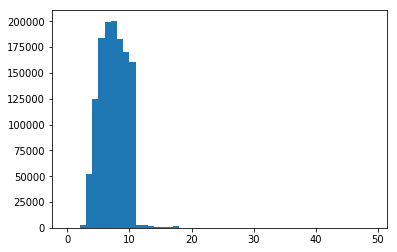

In [201]:
# Histogram of the lengths
%matplotlib inline

length_sentence = dataset_df.astype('str').applymap(lambda x: str(x).count(' ') + 1)
plt.hist(length_sentence['sentence'],bins=range(50))
plt.show()

### Shuffle the Dataset

In [28]:

index = [i for i in range(dataset_df.shape[0])]
random.shuffle(index)
dataset = dataset_df.set_index([index]).sort_index()

dataset.head(10)

,sentence,class
0,c è un'emergenza a casa sua,1
1,orecchini e maleducazione,0
2,comunque una volta compilato è la stessa cosa no?,1
3,perchè questa è la grecia,1
4,questa è stata scritta da un certo alonso bilac,1
5,se lo è non è delle migliori,1
6,chi è l'albert einstein di eureka?,1
7,e infatti devo fare il dolce per stasera,0
8,tu ti metti li' e aspetti,0
9,fortunatamente è perché sei gay,1


### Remove some punctuation and white spaces

In [29]:
exclude1 = ['\t', '"', '?', '!'] # list
exclude2 = ["'", "  ", "   ", "    ", "     "] # list

def clean_text(text):
    for c in exclude1:
        text=text.replace(c,'')
    for c in exclude2:
        text=text.replace(c, " ")
    return text.lower().strip()

sentence_processed = list(map(lambda text: clean_text(text), dataset['sentence'].values))

dataset['sentence'] = sentence_processed

dataset.head(10)

,sentence,class
0,c è un emergenza a casa sua,1
1,orecchini e maleducazione,0
2,comunque una volta compilato è la stessa cosa no,1
3,perchè questa è la grecia,1
4,questa è stata scritta da un certo alonso bilac,1
5,se lo è non è delle migliori,1
6,chi è l albert einstein di eureka,1
7,e infatti devo fare il dolce per stasera,0
8,tu ti metti li e aspetti,0
9,fortunatamente è perché sei gay,1


In [30]:
for i in range(6):
    print(dataset.iloc[i]['sentence'])
    print(dataset.iloc[-i -1]['sentence'])

c è un emergenza a casa sua
la mia dieta è un po diversa
orecchini e maleducazione
dadá è commosso
comunque una volta compilato è la stessa cosa no
accidenti è vero hai ragione
perchè questa è la grecia
stavamo ascoltando tutti e due
questa è stata scritta da un certo alonso bilac
dai loro una possibilita e io la daro a te
se lo è non è delle migliori
la nostra casa è ridotta in cenere


### Substitute ambiguities with a placeholder (tannutuva)

In [31]:
toSubstitute = ['e', 'è'] # list

# def substitute_amniguity_old(text, placeholder):
#     for c in toSubstitute:
#         text=text.replace(c,placeholder)
#     return text.lower().strip()

def substitute_amniguity(text, placeholder):
    for c in toSubstitute:
        text=re.sub(r"\b%s\b" %(c),placeholder, text)
    return text.lower().strip()

placeholder = 'tannutuva'
sentence_processed = list(map(lambda text: substitute_amniguity(text,placeholder), dataset['sentence'].values))

dataset['sentence'] = sentence_processed

dataset.head(5)

,sentence,class
0,c tannutuva un emergenza a casa sua,1
1,orecchini tannutuva maleducazione,0
2,comunque una volta compilato tannutuva la stes...,1
3,perchè questa tannutuva la grecia,1
4,questa tannutuva stata scritta da un certo alo...,1


### Split for Tagger Classifier (Train, Valid)

In [241]:

splitter =  model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=19850610)

splits = list(splitter.split(X=dataset['sentence'], y=dataset['class']))
train_index = splits[0][0]
valid_index = splits[0][1]

train_df = dataset.loc[train_index,:]
print('Training-Set size: %d' %len(train_df))

valid_df = dataset.loc[valid_index,:]
print('Validation-Set size: %d' %len(valid_df))

Training-Set size: 1159598
Validation-Set size: 128845


In [242]:
print("Training Set")
training_value_counts = train_df['class'].value_counts()
print(training_value_counts)
print("class 0 %: {}".format(round(training_value_counts[0]/len(train_df)*100,2)))
print("class 1 %: {}".format(round(training_value_counts[1]/len(train_df)*100,2)))
print("")
print("Validation Set")
validation_value_counts = valid_df['class'].value_counts()
print(validation_value_counts)
print("class 0 %: {}".format(round(validation_value_counts[0]/len(valid_df)*100,2)))
print("class 1 %: {}".format(round(validation_value_counts[1]/len(valid_df)*100,2)))

Training Set
1    614440
0    545158
Name: class, dtype: int64
class 0 %: 47.01
class 1 %: 52.99

Validation Set
1    68272
0    60573
Name: class, dtype: int64
class 0 %: 47.01
class 1 %: 52.99


In [243]:
train_df.to_csv(os.path.join(ROOT_PATH, 'datasets/è_e/train_data_v30.tsv'), header=False, index=False, sep='\t')
valid_df.to_csv(os.path.join(ROOT_PATH, 'datasets/è_e/valid_data_v30.tsv'), header=False, index=False, sep='\t')

## Calculate Vocabulary and Save it

In [32]:
stop_words = get_stop_words('italian') 

In [247]:

# This function returns FALSE if there is a digit in the string (i.e '4mmm', 'm44m', 'llp4')
falseIfDigit = lambda word: not bool((re.match('^(?=.*[0-9])', str(word))))

def get_vocab():
    #allWords = []
    vocab = set()
    for text in train_df['sentence'].values:
        words = text.split(' ')
        # remove digits
        words_only = [w for w in words if not w.isdigit()]
        # exclude words shorter than 2, but not numbers. exclude words with numbers inside, i.e. '3cris', 'c45ris', 'cris23'
        #words_ = [w for w in words_only if (falseIfDigit(w) or w.isdigit()) and (len(w) > 2 or w.isdigit()) ]
        words_ = [w for w in words_only if len(w) > 0 ]
        #allWords = allWords + words_
        word_set = set(words_)
        vocab.update(word_set)
    
    return list(vocab)#, allWords


from itertools import chain

def get_all_words():
    allWords = [text.split(' ') for text in train_df['sentence'].values]
    allWords = list(chain(*allWords))
    return allWords

In [249]:
%%time
vocab = get_vocab()
print('--------------------', len(vocab))


-------------------- 173215
CPU times: user 4.77 s, sys: 0 ns, total: 4.77 s
Wall time: 4.81 s


In [251]:
%%time
allWords = get_all_words()
print('--------------------', len(allWords))

-------------------- 8166341
CPU times: user 4.49 s, sys: 327 ms, total: 4.82 s
Wall time: 7.46 s


In [252]:
from collections import Counter
cnt_allWords = Counter(allWords)

In [253]:
vocab_words_sorted_by_appearence = sorted(cnt_allWords.items(), key=lambda kv: len(vocab) - kv[1])
#vocab_words_sorted_by_appearence

In [254]:
vocab_words_sorted_by_appearence_list = [word[0] for word in vocab_words_sorted_by_appearence]
#vocab_words_sorted_by_appearence_list, len(vocab_words_sorted_by_appearence_list)


In [255]:
#vocab_words_sorted_by_appearence_list

In [258]:
STOP_WORDS = False
REDUCED_SIZE_VOC = True
SIZE_VOC = 15000

vocab = vocab_words_sorted_by_appearence_list


if STOP_WORDS:
    vocab = [w for w in vocab if w not in stop_words]
    words_and_frequence = [ (word, freq) for (word, freq) in vocab_words_sorted_by_appearence if word not in stop_words]

print(len(vocab))
if REDUCED_SIZE_VOC:
    vocab = vocab[0:SIZE_VOC]
    

print(len(vocab))


175528
15000


In [272]:
adhoc_words = ['estinta', 'ballerina']

for word in adhoc_words:
    if word in vocab:
        continue
    else:
        vocab.append(word)
    
print(len(vocab))

15001


In [274]:
PAD_WORD = '#=KS=#'

PATH_VOC = os.path.join(ROOT_PATH, 'datasets/è_e/vocab_15k_swin_v30_tmp.tsv')
with open(PATH_VOC , 'w') as file:
#with open('/home/asr/Data/classif_task/jsgf_data/vocab_list.tsv', 'w') as file:
    file.write("{}\n".format(PAD_WORD))
    for word in vocab:
        file.write("{}\n".format(word))


In [275]:
! awk '! /^[0-9]+$/' /home/asr/prj_SlotTagger/dnn_train/datasets/è_e/vocab_15k_swin_v30_tmp.tsv |  sed '/^$/d'  > /home/asr/prj_SlotTagger/dnn_train/datasets/è_e/vocab_15k_swin_v30.tsv 

In [276]:
#! sed 's/[^a-zA-Z]//g' /home/asr/prj_SlotTagger/dnn_train/datasets/è_e/vocab_15k_swin_v13_tmp.tsv | awk '! /^[0-9]+$/' | sed '/^$/d' > /home/asr/prj_SlotTagger/dnn_train/datasets/è_e/vocab_15k_swin_v13.tsv 
! wc -l /home/asr/prj_SlotTagger/dnn_train/datasets/è_e/vocab_15k_swin_v30.tsv 

14890 /home/asr/prj_SlotTagger/dnn_train/datasets/è_e/vocab_15k_swin_v30.tsv


In [277]:
PATH_WORDS = os.path.join(ROOT_PATH, 'datasets/è_e/n_words_15k_swin_v30.tsv')        
with open(PATH_WORDS, 'w') as file:
#with open('/home/asr/Data/classif_task/jsgf_data/n_words.tsv', 'w') as file:
    file.write(str(14890))